In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import random
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import torchvision.transforms as transforms
import torch.optim as optim
from skimage import io
import torch.nn.functional as F
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR

In [2]:
data_dir="/kaggle/input/medical-scan-classification-dataset/Alzheimer/Alzheimer/MRI"
classes=["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]
labels={"id":[], "label":[]}
for classname in classes:
    for image in os.listdir(data_dir+f"/{classname}"):
        labels["id"].append(data_dir+f"/{classname}/{image}")
        labels["label"].append(classname)
labels=pd.DataFrame(labels)
labels.to_csv("labels.csv", index=False)

In [3]:
labels=pd.read_csv("/kaggle/working/labels.csv")
labels

,id,label
0,/kaggle/input/medical-scan-classification-data...,MildDemented
1,/kaggle/input/medical-scan-classification-data...,MildDemented
2,/kaggle/input/medical-scan-classification-data...,MildDemented
3,/kaggle/input/medical-scan-classification-data...,MildDemented
4,/kaggle/input/medical-scan-classification-data...,MildDemented
...,...,...
35197,/kaggle/input/medical-scan-classification-data...,VeryMildDemented
35198,/kaggle/input/medical-scan-classification-data...,VeryMildDemented
35199,/kaggle/input/medical-scan-classification-data...,VeryMildDemented
35200,/kaggle/input/medical-scan-classification-data...,VeryMildDemented


In [4]:
labels["id"][0]

'/kaggle/input/medical-scan-classification-dataset/Alzheimer/Alzheimer/MRI/MildDemented/b063b988-374f-4665-a4b1-3a49cbe6c44f.jpg'

In [5]:
label_count=labels.groupby(by="label", as_index=False).count().sort_values(by="id", ascending=False)
label_count

,label,id
2,NonDemented,12800
3,VeryMildDemented,11200
1,ModerateDemented,6528
0,MildDemented,4674


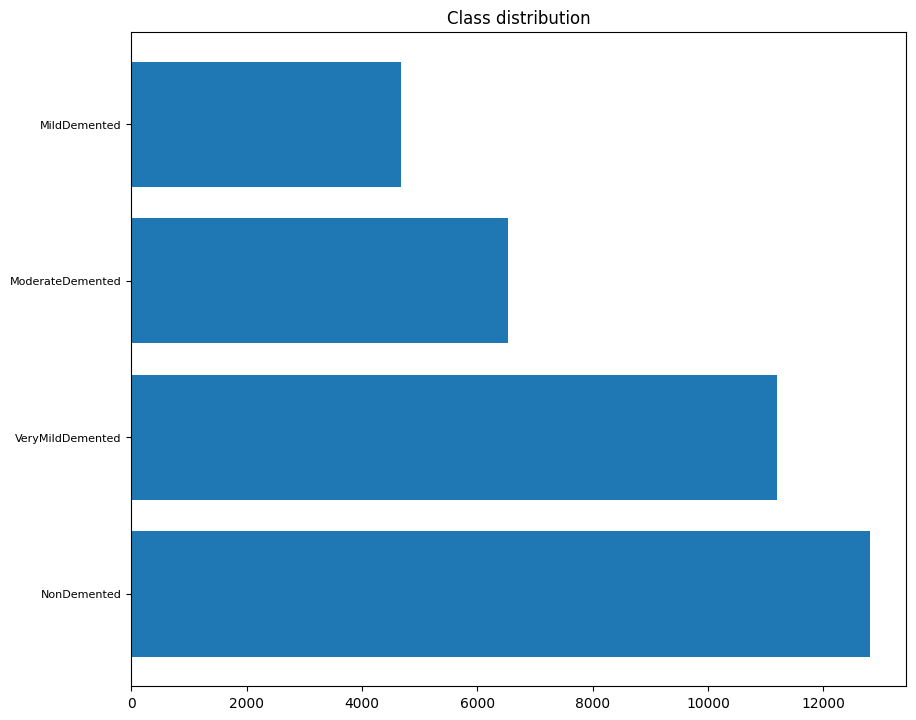

In [6]:
fig, ax = plt.subplots(figsize=(10, 8.5))
ax=plt.barh(label_count["label"], label_count["id"])
plt.title("Class distribution")
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 8) 
plt.show()

In [7]:
random.seed=42
train_indices=random.sample(list(range(len(labels))), int(len(labels)*0.8))
test_indices=[i for i in list(range(len(labels))) if i not in train_indices]

In [8]:
test_labels=labels.drop(train_indices).reset_index(drop=True)
test_labels

,id,label
0,/kaggle/input/medical-scan-classification-data...,MildDemented
1,/kaggle/input/medical-scan-classification-data...,MildDemented
2,/kaggle/input/medical-scan-classification-data...,MildDemented
3,/kaggle/input/medical-scan-classification-data...,MildDemented
4,/kaggle/input/medical-scan-classification-data...,MildDemented
...,...,...
7036,/kaggle/input/medical-scan-classification-data...,VeryMildDemented
7037,/kaggle/input/medical-scan-classification-data...,VeryMildDemented
7038,/kaggle/input/medical-scan-classification-data...,VeryMildDemented
7039,/kaggle/input/medical-scan-classification-data...,VeryMildDemented


In [9]:
train_labels=labels.drop(test_indices).reset_index(drop=True)
train_labels

,id,label
0,/kaggle/input/medical-scan-classification-data...,MildDemented
1,/kaggle/input/medical-scan-classification-data...,MildDemented
2,/kaggle/input/medical-scan-classification-data...,MildDemented
3,/kaggle/input/medical-scan-classification-data...,MildDemented
4,/kaggle/input/medical-scan-classification-data...,MildDemented
...,...,...
28156,/kaggle/input/medical-scan-classification-data...,VeryMildDemented
28157,/kaggle/input/medical-scan-classification-data...,VeryMildDemented
28158,/kaggle/input/medical-scan-classification-data...,VeryMildDemented
28159,/kaggle/input/medical-scan-classification-data...,VeryMildDemented


In [10]:
train_labels.to_csv('train_labels.csv',index=False)
test_labels.to_csv('test_labels.csv',index=False)

In [11]:
map_labels = dict()
for index, row in label_count.reset_index(drop=True).iterrows():
    map_labels[row["label"]] = index
    
print(len(map_labels))
map_labels

4


{'NonDemented': 0,
 'VeryMildDemented': 1,
 'ModerateDemented': 2,
 'MildDemented': 3}

In [12]:
inverse_map=dict()
for label in map_labels:
    inverse_map[map_labels[label]]=label
inverse_map

{0: 'NonDemented',
 1: 'VeryMildDemented',
 2: 'ModerateDemented',
 3: 'MildDemented'}

# Dataset functions

In [13]:
def grayscale_to_rgb(images):
    return np.repeat(images[..., np.newaxis], 3, axis=-1)

def grayscale_to_rgb_skimage(gray_image_array):
    """
    Converts a grayscale image loaded with scikit-image to an RGB image by duplicating 
    the grayscale values across R, G, and B channels.
    
    Parameters:
        gray_image_array (numpy.ndarray): A 2D array representing a grayscale image.
        
    Returns:
        numpy.ndarray: A 3D array representing an RGB image.
    """
    if gray_image_array.ndim != 2:
        raise ValueError("Input array must be a 2D grayscale image.")
    
    # Stack the grayscale channel across three channels (R, G, B)
    rgb_image_array = np.stack((gray_image_array,)*3, axis=-1)
    return rgb_image_array

In [14]:
class MRIDataset_train(Dataset):
    def __init__(self, csv_file, transform=None):
        self.labels = pd.read_csv(csv_file)
        #self.root_dir = root_dir
        self.transform = transform['train']
        #self.labels=csv_file
        
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, index):
        #img_path = os.path.join(self.root_dir, self.labels.iloc[index, 0])
        img_path=self.labels.iloc[index, 0]
        image = io.imread(img_path)
        y_label = torch.tensor(int(map_labels[self.labels.iloc[index, 1]]))


        if self.transform:
            image = self.transform(image)
        return (image, y_label)

In [15]:
class MRIDataset_test(Dataset):
    def __init__(self, csv_file, transform=None):
        self.name_images = pd.read_csv(csv_file)['id'].values
        #self.root_dir = root_dir
        self.transform = transform['test']
        self.labels=pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.name_images)
    
    def __getitem__(self, index):
        #img_path = os.path.join(self.root_dir, self.name_images[index])
        img_path=self.labels.iloc[index, 0]
        image = io.imread(img_path)
     
        if self.transform:
            image = self.transform(image)

        return image

In [16]:
transform ={'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(3),
        transforms.Resize((224, 224)),
        #transforms.RandomRotation(degrees=15),
        #transforms.ColorJitter(),
        #transforms.RandomHorizontalFlip(),
        #transforms.CenterCrop(size=224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])]),
    'test': transforms.Compose([transforms.ToPILImage(),
                                    transforms.Grayscale(3),
                                    transforms.Resize((224, 224)),
                                    #transforms.CenterCrop(size=224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])}


In [17]:
num_classes = 4
learning_rate = 1e-3
batch_size = 128
num_epochs = 15
lr_ratio=0.005

In [18]:
dataset = MRIDataset_train('/kaggle/working/train_labels.csv', transform)
train_set_size = int(len(dataset) * 0.8)
print("Train set length: ", train_set_size)
valid_set_size = len(dataset) - train_set_size
print("Validation set length: ", valid_set_size)
train_set, valid_set = torch.utils.data.random_split(dataset, [train_set_size, valid_set_size])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)

test_data = MRIDataset_test('/kaggle/working/test_labels.csv', transform=transform)
print("Test set length: ",len(test_data))
test_loader = DataLoader(test_data, batch_size=batch_size)

Train set length:  22528
Validation set length:  5633
Test set length:  7041


## Functions for training

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device")
print(device)

Device
cuda


In [20]:
# save checkpoint
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    torch.save(state, filename)

# load checkpint
def load_checkpoint(checkpoint, model, optimizer):
    print("Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scheduler = checkpoint['scheduler']

In [21]:
def plot_results(training_accuracy_list, training_loss_list, validation_accuracy_list, validation_loss_list):
    epochs = len(training_accuracy_list)
    x = np.arange(1, epochs + 1)

    training_accuracy_list = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in training_accuracy_list]
    training_loss_list = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in training_loss_list]
    validation_accuracy_list = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in validation_accuracy_list]
    best_loss_list = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in validation_loss_list]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(x, training_accuracy_list, label='Training Accuracy', color='blue')
    axes[1].plot(x, training_loss_list, label='Training Loss', color='orange')
    axes[0].plot(x, validation_accuracy_list, label='Validation Accuracy', color='green')
    axes[1].plot(x, best_loss_list, label='Validation Loss', color='red')

    fig.suptitle('Model Evaluation Metrics')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    axes[0].grid(True)
    axes[1].set_xlabel('Epochs')
    axes[1].legend()
    axes[1].grid(True)
    plt.show()

In [22]:
def traindata(device, model, epochs, optimizer, scheduler, loss_function, train_loader, valid_loader, filename):
    # Early stopping
    best_loss = 100
    patience = 5
    trigger_times = 0

    # Lists to store data for plotting
    training_accuracy_list = []
    training_loss_list = []
    best_loss_list = []
    validation_accuracy_list = []
    validation_loss_list = []

    for epoch in range(1, epochs+1):
        model.train()
        correct = 0
        loss_total = 0
        for data in train_loader:
            input = data[0].to(device)
            label = data[1].to(device)

            optimizer.zero_grad()

            output = model(input)
            _, predicted = output.max(1)
            loss = loss_function(output, label)
            loss_total += loss.item()
            correct+= (predicted == label).sum()
            loss.backward()
            optimizer.step()
            scheduler.step()

        training_accuracy = correct/len(train_loader.sampler)
        training_loss = loss_total/len(train_loader)

        print('{}. epoch'.format(epoch))
        

         # Early stopping
        current_loss, validation_accuracy = validation(model, device, valid_loader, loss_function)
        print('Training accuracy: {} Training loss: {} \nValidation accuracy: {} Validation loss: {}'.format(training_accuracy, training_loss, validation_accuracy, current_loss))

        # Append values to lists for plotting
        training_accuracy_list.append(training_accuracy)
        training_loss_list.append(training_loss)
        validation_accuracy_list.append(validation_accuracy)
        validation_loss_list.append(current_loss)
        best_loss_list.append(best_loss)

        if current_loss > best_loss:
            trigger_times += 1

            if trigger_times >= patience:
                print('Early stopping! Start to test process.')
                break
        else:
            trigger_times = 0
            save_checkpoint(checkpoint, filename)
            best_loss = current_loss

    # Plot the results
    plot_results(training_accuracy_list, training_loss_list, validation_accuracy_list, validation_loss_list)

    return model

In [23]:
def validation(model, device, valid_loader, loss_function):

    model.eval()
    loss_total = 0
    correct = 0
    
    with torch.no_grad():
        for data in valid_loader:
            input = data[0].to(device)
            label = data[1].to(device)
            output = model(input)
            _, predicted = output.max(1)
            loss = loss_function(output, label)
            loss_total += loss.item()
            correct+= (predicted == label).sum()
        validation_accuracy = correct/len(valid_loader.sampler)
    return loss_total / len(valid_loader), validation_accuracy

In [24]:
def test(device, model, test_loader, loss_function):
    model.eval()
    predictions = pd.DataFrame()
    with torch.no_grad():
        for data in test_loader:
            input = data.to(device)
            output = model(input)
            m = nn.Softmax(dim=1)
            res = m(output)
            predictions = pd.concat([predictions, pd.DataFrame(torch.Tensor.cpu(res).numpy(), columns = list(map_labels.keys()))], ignore_index=True)
        return (predictions)

# ResNet50

In [25]:
model_resnet = models.resnet50(pretrained=True)

for param in model_resnet.parameters():
    param.requires_grad = False
    
model_resnet.fc = nn.Linear(2048, num_classes) 
model_resnet = model_resnet.to(device=device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 75.5MB/s]


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * lr_ratio)
checkpoint = {"state_dict": model_resnet.state_dict(), "optimizer": optimizer.state_dict(), "scheduler": scheduler}

1. epoch
Training accuracy: 0.5456765294075012 Training loss: 1.0453980727629228 
Validation accuracy: 0.6087342500686646 Validation loss: 0.9275258183479309
2. epoch
Training accuracy: 0.6245561242103577 Training loss: 0.8770346939563751 
Validation accuracy: 0.6426416039466858 Validation loss: 0.832113966345787
3. epoch
Training accuracy: 0.6455966234207153 Training loss: 0.8239810727536678 
Validation accuracy: 0.6513403654098511 Validation loss: 0.8046871993276808
4. epoch
Training accuracy: 0.6556285619735718 Training loss: 0.7971719439056787 
Validation accuracy: 0.6586188673973083 Validation loss: 0.789956165684594
5. epoch
Training accuracy: 0.6664595603942871 Training loss: 0.7742254432629455 
Validation accuracy: 0.6660749316215515 Validation loss: 0.7853395925627814
6. epoch
Training accuracy: 0.6641069054603577 Training loss: 0.7654837119308385 
Validation accuracy: 0.6571986675262451 Validation loss: 0.7793238931232028
7. epoch
Training accuracy: 0.6667258739471436 Trainin

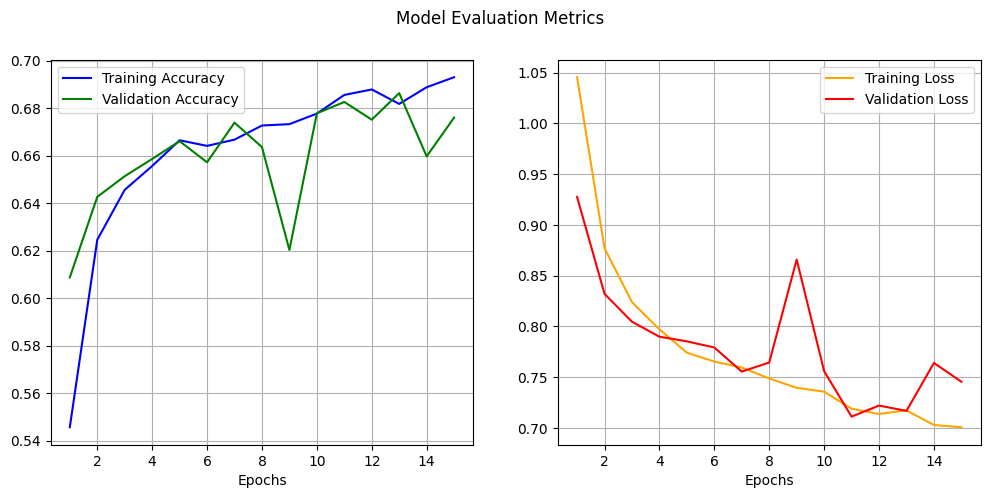

In [27]:
model = traindata(device, model_resnet, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, "resnet_checkpoint.pth.tar")

In [28]:
load_checkpoint(torch.load("resnet_checkpoint.pth.tar"), model_resnet, optimizer)

Loading checkpoint


/tmp/ipykernel_24/4100813766.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("resnet_checkpoint.pth.tar"), model_resnet, optimizer)


In [29]:
df = test(device, model, test_loader, criterion)
df=pd.concat([df, test_labels["label"]], axis=1)
df.to_csv('resnet50.csv', index=False)
df

,NonDemented,VeryMildDemented,ModerateDemented,MildDemented,label
0,0.267435,0.375638,0.049969,0.306958,MildDemented
1,0.267233,0.322682,0.109269,0.300816,MildDemented
2,0.236013,0.465062,0.113979,0.184946,MildDemented
3,0.256577,0.108409,0.006749,0.628266,MildDemented
4,0.078587,0.406770,0.000743,0.513901,MildDemented
...,...,...,...,...,...
7036,0.177614,0.699728,0.001379,0.121278,VeryMildDemented
7037,0.324120,0.643464,0.000308,0.032109,VeryMildDemented
7038,0.341557,0.466079,0.066191,0.126173,VeryMildDemented
7039,0.042641,0.561209,0.052683,0.343467,VeryMildDemented


# VGG16

In [30]:
# Load the VGG16 model
model_vgg = models.vgg16(pretrained=True)

# Freeze the parameters
for param in model_vgg.parameters():
    param.requires_grad = False

# Replace the last layer to match the number of classes
model_vgg.classifier[6] = nn.Linear(4096, num_classes) # number of classes
model_vgg = model_vgg.to(device=device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 225MB/s]


In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * lr_ratio)
checkpoint = {"state_dict": model_vgg.state_dict(), "optimizer": optimizer.state_dict(), "scheduler": scheduler}

1. epoch
Training accuracy: 0.46493253111839294 Training loss: 1.177272412587296 
Validation accuracy: 0.5510385632514954 Validation loss: 0.9999812960624694
2. epoch
Training accuracy: 0.5358220934867859 Training loss: 1.0278520919382572 
Validation accuracy: 0.5957749485969543 Validation loss: 0.9465260783831279
3. epoch
Training accuracy: 0.5435458421707153 Training loss: 1.00399905747988 
Validation accuracy: 0.6106870174407959 Validation loss: 0.9038202404975891
4. epoch
Training accuracy: 0.5539329051971436 Training loss: 0.9878189729695971 
Validation accuracy: 0.6229363083839417 Validation loss: 0.885967222849528
5. epoch
Training accuracy: 0.5553977489471436 Training loss: 0.9733968871560964 
Validation accuracy: 0.6211610436439514 Validation loss: 0.8655947354104784
6. epoch
Training accuracy: 0.5632102489471436 Training loss: 0.9644773924215273 
Validation accuracy: 0.6403337717056274 Validation loss: 0.8454788181516859
7. epoch
Training accuracy: 0.5644087791442871 Training

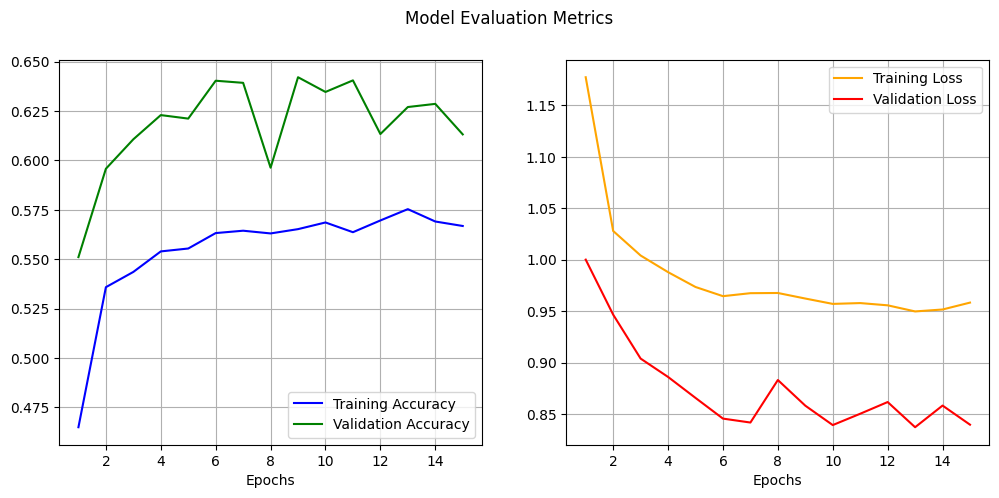

In [32]:
model2 = traindata(device, model_vgg, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, "vgg_checkpoint.pth.tar")

In [33]:
load_checkpoint(torch.load("vgg_checkpoint.pth.tar"), model_vgg, optimizer)

/tmp/ipykernel_24/1595752799.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("vgg_checkpoint.pth.tar"), model_vgg, optimizer)


Loading checkpoint


In [34]:
df = test(device, model2, test_loader, criterion)
df=pd.concat([df, test_labels["label"]], axis=1)
df.to_csv('vgg16.csv', index=False)
df

,NonDemented,VeryMildDemented,ModerateDemented,MildDemented,label
0,0.343552,0.306447,0.028076,0.321926,MildDemented
1,0.348842,0.502676,0.020596,0.127886,MildDemented
2,0.144685,0.252740,0.403975,0.198600,MildDemented
3,0.111231,0.204908,0.343646,0.340216,MildDemented
4,0.333349,0.329330,0.058023,0.279298,MildDemented
...,...,...,...,...,...
7036,0.474828,0.329486,0.036615,0.159071,VeryMildDemented
7037,0.465036,0.431833,0.020938,0.082193,VeryMildDemented
7038,0.251493,0.250295,0.194374,0.303838,VeryMildDemented
7039,0.216980,0.438623,0.118731,0.225667,VeryMildDemented


# EfficientNet

In [35]:
# Load the EfficientNet-B0 model
model_efficientnet = models.efficientnet_b0(pretrained=True)

# Freeze the parameters
for param in model_efficientnet.parameters():
    param.requires_grad = False

# Replace the classifier to match the number of classes
model_efficientnet.classifier[1] = nn.Linear(model_efficientnet.classifier[1].in_features, num_classes)

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_efficientnet = model_efficientnet.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 127MB/s] 


In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_efficientnet.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * lr_ratio)
checkpoint = {"state_dict": model_efficientnet.state_dict(), "optimizer": optimizer.state_dict(), "scheduler": scheduler}

1. epoch
Training accuracy: 0.5264115929603577 Training loss: 1.081363172693686 
Validation accuracy: 0.6147701144218445 Validation loss: 0.934409745534261
2. epoch
Training accuracy: 0.6007190942764282 Training loss: 0.9313837167891589 
Validation accuracy: 0.637493371963501 Validation loss: 0.864533801873525
3. epoch
Training accuracy: 0.6159890294075012 Training loss: 0.8845543952828104 
Validation accuracy: 0.644416868686676 Validation loss: 0.8076350604494412
4. epoch
Training accuracy: 0.6299272179603577 Training loss: 0.852713801982728 
Validation accuracy: 0.6525830030441284 Validation loss: 0.7922192639774747
5. epoch
Training accuracy: 0.6337003111839294 Training loss: 0.8379341814328324 
Validation accuracy: 0.6568436026573181 Validation loss: 0.7696998231940799
6. epoch
Training accuracy: 0.6417791247367859 Training loss: 0.8242041299288924 
Validation accuracy: 0.6591514348983765 Validation loss: 0.7605049514108234
7. epoch
Training accuracy: 0.640269935131073 Training los

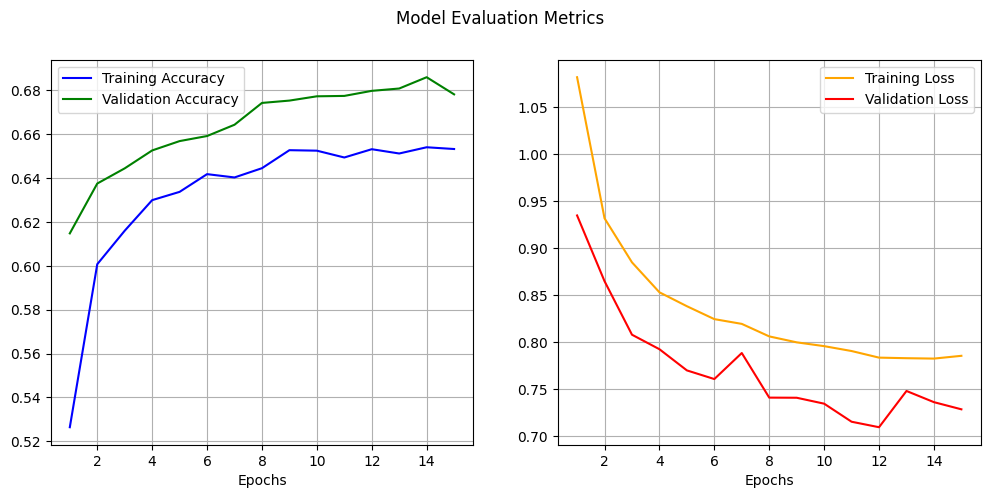

In [37]:
model_eff = traindata(device, model_efficientnet, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, "effnet_checkpoint.pth.tar")

In [38]:
load_checkpoint(torch.load("effnet_checkpoint.pth.tar"), model_efficientnet, optimizer)

Loading checkpoint


/tmp/ipykernel_24/52900786.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("effnet_checkpoint.pth.tar"), model_efficientnet, optimizer)


In [39]:
df = test(device, model_eff, test_loader, criterion)
df=pd.concat([df, test_labels["label"]], axis=1)
df.to_csv('efficientnet.csv', index=False)
df

,NonDemented,VeryMildDemented,ModerateDemented,MildDemented,label
0,0.338614,0.380192,0.069547,0.211648,MildDemented
1,0.309467,0.640448,0.000106,0.049979,MildDemented
2,0.232600,0.368637,0.127384,0.271379,MildDemented
3,0.262464,0.390683,0.074320,0.272534,MildDemented
4,0.187250,0.348612,0.003545,0.460593,MildDemented
...,...,...,...,...,...
7036,0.364146,0.530306,0.040592,0.064956,VeryMildDemented
7037,0.522046,0.349964,0.003077,0.124913,VeryMildDemented
7038,0.472159,0.483042,0.011327,0.033472,VeryMildDemented
7039,0.102125,0.606126,0.004921,0.286829,VeryMildDemented


# MobileNetV2

In [40]:
# Load the MobileNetV2 model
model_mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze the parameters
for param in model_mobilenet.parameters():
    param.requires_grad = False

# Replace the classifier to match the number of classes
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.last_channel, num_classes)

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_mobilenet = model_mobilenet.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 108MB/s] 


In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mobilenet.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * lr_ratio)
checkpoint = {"state_dict": model_mobilenet.state_dict(), "optimizer": optimizer.state_dict(), "scheduler": scheduler}

1. epoch
Training accuracy: 0.5296964049339294 Training loss: 1.0599707375195893 
Validation accuracy: 0.6073140501976013 Validation loss: 0.9353535665406121
2. epoch
Training accuracy: 0.6174538731575012 Training loss: 0.8922407362948764 
Validation accuracy: 0.644416868686676 Validation loss: 0.8424308882819281
3. epoch
Training accuracy: 0.6357865929603577 Training loss: 0.8428775803609327 
Validation accuracy: 0.6591514348983765 Validation loss: 0.8090807729297214
4. epoch
Training accuracy: 0.6459517478942871 Training loss: 0.8141739046709104 
Validation accuracy: 0.6644772291183472 Validation loss: 0.7749673869874742
5. epoch
Training accuracy: 0.6546964049339294 Training loss: 0.7974847030233253 
Validation accuracy: 0.6600390672683716 Validation loss: 0.786230190594991
6. epoch
Training accuracy: 0.6584694981575012 Training loss: 0.7827989306639541 
Validation accuracy: 0.6726433634757996 Validation loss: 0.744939982228809
7. epoch
Training accuracy: 0.6644620299339294 Training

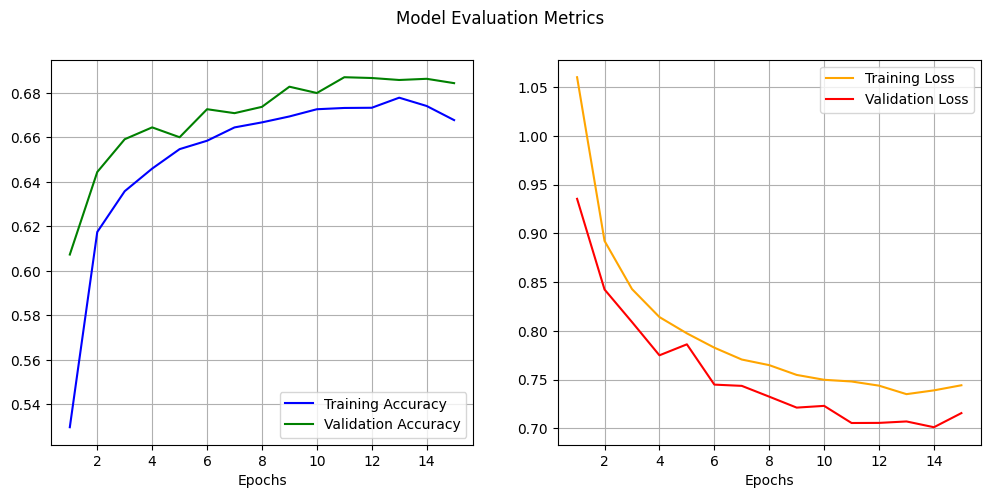

In [42]:
model_mob = traindata(device, model_mobilenet, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, "mobnet_checkpoint.pth.tar")

In [43]:
load_checkpoint(torch.load("mobnet_checkpoint.pth.tar"), model_mobilenet, optimizer)

Loading checkpoint


/tmp/ipykernel_24/2580840668.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("mobnet_checkpoint.pth.tar"), model_mobilenet, optimizer)


In [44]:
df = test(device, model_mob, test_loader, criterion)
df=pd.concat([df, test_labels["label"]], axis=1)
df.to_csv('mobilenet.csv', index=False)
df

,NonDemented,VeryMildDemented,ModerateDemented,MildDemented,label
0,0.356758,0.325738,0.000725,0.316780,MildDemented
1,0.126674,0.744699,0.069931,0.058697,MildDemented
2,0.436396,0.410634,0.062626,0.090343,MildDemented
3,0.075351,0.269445,0.363466,0.291738,MildDemented
4,0.112401,0.291813,0.039743,0.556044,MildDemented
...,...,...,...,...,...
7036,0.745461,0.241308,0.000471,0.012761,VeryMildDemented
7037,0.507350,0.327903,0.019023,0.145724,VeryMildDemented
7038,0.206130,0.465527,0.064277,0.264066,VeryMildDemented
7039,0.075481,0.714264,0.013834,0.196422,VeryMildDemented


# Evaluation

In [45]:
resnet50=pd.read_csv("/kaggle/working/resnet50.csv")
effnet=pd.read_csv("/kaggle/working/efficientnet.csv")
mobnet=pd.read_csv("/kaggle/working/mobilenet.csv")
vgg=pd.read_csv("/kaggle/working/vgg16.csv")

In [46]:
def top_p_percent_acc(data, p):
    cat_num=len(list(data.columns))-1  #number of categories = number of columns - 2 (number of picture, true_label)
    test_size=len(list(data.index)) #number of validation data points
    p_percent=int(p/100*cat_num) #p percent of the validation size
    acc=0
    for row,i in data.iterrows():
        best_p_indices=np.array(i[:len(i)-1]).argsort()[-p_percent:][::-1]  #the p% largest probabilities
        best_p_columns=[data.columns[j] for j in best_p_indices]  #the corresponding classes
        true_label=str(i["label"]) #str(train.loc[i["picture"],"landmark_id"])  #the true class of the data point
        if true_label in best_p_columns:
            acc+=1
    acc=acc/test_size
    return acc

In [47]:
def top_p_percent_plot(data, P_list):
    cat_num=len(list(data.columns))-1  #number of categories = number of columns - 2 (number of picture, true_label)
    test_size=len(list(data.index)) #number of validation data points

    values=[]
    for p in P_list:
        acc=top_p_percent_acc(data, p)
        values.append(acc)

    plt.plot(P_list, values, color="green")
    plt.title('P-percent accuracies')
    plt.xlabel('P values')
    plt.ylabel('P-Accuracy')
    #plt.ylim([-0.05, 1.05])

    plt.show()

In [48]:
def multiple_data_ppercent(l):
    cat_num=len(list(l[0][0].columns))-1 
    test_size=len(list(l[0][0].index))
    for i in l:
        data, P_list, name = i
        values=[]
        for p in P_list:
            acc=top_p_percent_acc(data, p)
            values.append(acc)
        plt.plot(P_list, values, label=name)
    plt.title('P-percent accuracies')
    plt.xlabel('P values')
    plt.ylabel('P-Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

In [49]:
def acc_class_size(data, title):  #we would like to investigate if the the accuracy and the size of the class are correlated
    accuracies=[] #this list will contain the accuracies of the classes
    sizes=[]
    #for class_num in data.columns[:len(data.columns)-2]:
        #accuracies=[] #this list will contain the accuracies of the classes
    for class_name in data.columns[:len(data.columns)-1]:
        class_data=data[data["label"]==str(class_name)] #validation data points from this class
        acc=top_p_percent_acc(class_data, 2)    #accuracy of the validation data from this class
        accuracies.append(acc)
        #class_data=data[data["original_class"]==float(class_num)]  #validation data points from this class
        #acc=top_p_percent_acc(class_data, 2)    #accuracy of the validation data from this class
        #accuracies.append(acc)
        #class_size=train_labels[train_labels["breed"]==class_name]["label_count"].values[0] #size of the class
        class_size=labels[labels["label"]==class_name]["id"].values[0]
        sizes.append(class_size)
    order=np.array(accuracies).argsort() #order the two list according to the accuracies
    accuracies=[accuracies[i] for i in order]
    sizes=[sizes[i] for i in order]
    sizes=[(sizes[i]-min(sizes))/(max(sizes)-min(sizes)) for i in range(len(sizes))] #normalize the sizes into [0, 1]
    corr=round(np.corrcoef(accuracies, sizes)[0, 1],4)
    label="corr="+str(corr)
    plt.scatter(accuracies, sizes, label=label)
    plt.title(title)
    plt.ylabel("Size of the class")
    plt.xlabel("Accuracy of the class")
    plt.legend()
    plt.show()

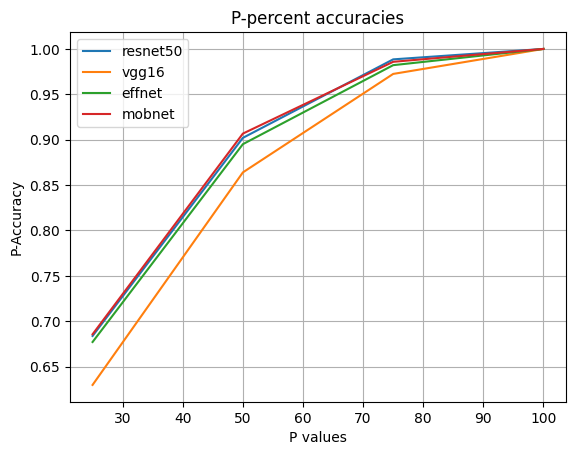

In [50]:
p=[25, 50, 75, 100]
multiple_data_ppercent([[resnet50, p, "resnet50"], [vgg, p, "vgg16"], [effnet, p, "effnet"], [mobnet, p, "mobnet"]])